In [8]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import io, filters
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add path to import from module1
sys.path.append('..')

# Import the sophisticated background removal functions from Module 1
def apply_grabcut_auto(image: np.ndarray) -> np.ndarray:
    """Apply GrabCut with automatic rectangle initialization."""
    height, width = image.shape[:2]
    
    # Create initial rectangle (avoid edges where background typically is)
    margin_x = int(width * 0.1)
    margin_y = int(height * 0.1)
    rect = (margin_x, margin_y, width - 2*margin_x, height - 2*margin_y)
    
    # Initialize masks
    mask = np.zeros((height, width), np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    
    # Create binary mask
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    return mask2 * 255

def apply_advanced_color_segmentation(image: np.ndarray) -> np.ndarray:
    """Apply advanced color-based segmentation using multiple color spaces."""
    height, width = image.shape[:2]
    
    # Convert to multiple color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # HSV-based mask
    h, s, v = cv2.split(hsv)
    
    # Adaptive thresholding for saturation
    s_thresh = cv2.adaptiveThreshold(s, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -5)
    
    # Value thresholding to remove very dark areas
    _, v_thresh = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # LAB-based mask focusing on A and B channels (color information)
    l, a, b = cv2.split(lab)
    
    # Enhance color channels
    a_enhanced = cv2.equalizeHist(a)
    b_enhanced = cv2.equalizeHist(b)
    
    # Combine color information
    color_mask = cv2.bitwise_and(s_thresh, v_thresh)
    
    # Add edge information
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    
    # Dilate edges to create regions
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Combine all masks
    combined_mask = cv2.bitwise_or(color_mask, edges_dilated)
    
    # Fill holes
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(combined_mask)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > (height * width * 0.001):  # Filter small noise
            cv2.fillPoly(filled_mask, [contour], (255,))
    
    return filled_mask

def evaluate_mask_quality(mask: np.ndarray, image: np.ndarray) -> float:
    """Evaluate the quality of a segmentation mask."""
    height, width = image.shape[:2]
    total_pixels = height * width
    
    # Foreground percentage (should be reasonable, not too small or too large)
    fg_pixels = np.sum(mask > 0)
    fg_ratio = fg_pixels / total_pixels
    
    # Penalize masks that are too small (< 5%) or too large (> 80%)
    if fg_ratio < 0.05 or fg_ratio > 0.8:
        size_score = 0.0
    else:
        size_score = 1.0 - abs(0.3 - fg_ratio) / 0.3  # Optimal around 30%
    
    # Edge coherence: measure how well edges align with mask boundaries
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    
    mask_edges = cv2.Canny(mask, 50, 150)
    edge_overlap = np.sum((edges > 0) & (mask_edges > 0))
    edge_score = edge_overlap / (np.sum(mask_edges > 0) + 1)
    
    # Compactness: prefer connected components
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        compact_score = 0.0
    else:
        largest_area = max(cv2.contourArea(c) for c in contours)
        total_area = np.sum(mask > 0)
        compact_score = largest_area / (total_area + 1)
    
    # Combined score
    total_score = 0.4 * size_score + 0.3 * edge_score + 0.3 * compact_score
    return total_score

def post_process_mask(mask: np.ndarray, image: np.ndarray) -> np.ndarray:
    """Post-process mask to improve quality."""
    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Fill holes in the largest connected component
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Keep only the largest connected component
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Create new mask with only the largest component
        final_mask = np.zeros_like(mask)
        cv2.fillPoly(final_mask, [largest_contour], (255,))
        
        return final_mask
    
    return mask

def remove_background(image_array: np.ndarray) -> np.ndarray:
    """
    Adapted version of Module 1's sophisticated background removal.
    Works with numpy arrays directly using the proven multi-method approach.
    
    Args:
        image_array: numpy array of shape (H, W, 3) with values in range [0, 1]
    
    Returns:
        numpy array with background removed (background set to transparent/white)
    """
    # Convert from [0,1] RGB to [0,255] BGR for OpenCV
    image_bgr = (image_array[:, :, ::-1] * 255).astype(np.uint8)  # RGB to BGR and scale
    
    # Try multiple methods in order of sophistication  
    methods = [
        ('grabcut_auto', apply_grabcut_auto),
        ('advanced_color', apply_advanced_color_segmentation),
    ]
    
    best_mask = None
    best_score = 0
    
    print("🔍 Trying Module 1's sophisticated background removal methods...")
    
    for method_name, method_func in methods:
        try:
            mask = method_func(image_bgr)
            score = evaluate_mask_quality(mask, image_bgr)
            
            print(f"  Method {method_name}: quality score = {score:.3f}")
            
            if score > best_score:
                best_mask = mask
                best_score = score
                
            # If we get a good enough result, use it
            if score > 0.6:
                print(f"  ✅ Using {method_name} (score: {score:.3f})")
                break
                
        except Exception as e:
            print(f"  ⚠️ Method {method_name} failed: {e}")
            continue
    
    if best_mask is None:
        print("  🔧 All methods failed, using simple fallback")
        # Simple fallback
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        _, best_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Post-process the mask
    final_mask = post_process_mask(best_mask, image_bgr)
    
    # Apply mask to original image (keep RGB format and [0,1] range)
    result = image_array.copy()
    
    # Convert mask to 3D and normalize
    mask_3d = np.stack([final_mask/255.0] * 3, axis=2)
    
    # Apply mask: keep foreground, set background to white
    result = result * mask_3d + (1 - mask_3d)  # Background becomes white
    
    print(f"  ✅ Background removal completed with score: {best_score:.3f}")
    
    return result

# Set random seed for reproducibility
np.random.seed(42)
print("📦 All libraries imported successfully")
print("✅ Using Module 1's proven background removal methods (adapted for numpy arrays)")


📦 All libraries imported successfully
✅ Using Module 1's proven background removal methods (adapted for numpy arrays)


In [9]:
# Enhanced Implementation of Alternative Quality Assessment Metrics

def calculate_fsim(img1, img2):
    """Calculate Feature Similarity Index (FSIM) - Enhanced Implementation"""
    # Convert to grayscale if needed
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
        gray2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    else:
        gray1, gray2 = img1, img2
    
    # Calculate gradients using Sobel operators
    gx1 = cv2.Sobel(gray1, cv2.CV_64F, 1, 0, ksize=3)
    gy1 = cv2.Sobel(gray1, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = cv2.Sobel(gray2, cv2.CV_64F, 1, 0, ksize=3)
    gy2 = cv2.Sobel(gray2, cv2.CV_64F, 0, 1, ksize=3)
    
    # Gradient magnitudes
    gm1 = np.sqrt(gx1**2 + gy1**2)
    gm2 = np.sqrt(gx2**2 + gy2**2)
    
    # Phase congruency approximation (enhanced)
    pc1 = gm1 / (gm1 + 0.1)
    pc2 = gm2 / (gm2 + 0.1)
    
    # Similarity measures with appropriate constants
    T1, T2 = 0.85, 0.85
    pc_sim = (2 * pc1 * pc2 + T1) / (pc1**2 + pc2**2 + T1)
    gm_sim = (2 * gm1 * gm2 + T2) / (gm1**2 + gm2**2 + T2)
    
    # Combined similarity
    sl = pc_sim * gm_sim
    pcm = np.maximum(pc1, pc2)
    
    # FSIM calculation with improved normalization
    fsim = np.sum(sl * pcm) / (np.sum(pcm) + 1e-10)
    return float(np.clip(fsim, 0, 1))

def calculate_vif(img1, img2):
    """Calculate Visual Information Fidelity (VIF) - Simplified Implementation"""
    # Convert to grayscale if needed
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float64) / 255.0
        gray2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float64) / 255.0
    else:
        gray1, gray2 = img1.astype(np.float64), img2.astype(np.float64)
    
    # Multi-scale analysis
    vif_val = 0
    num_scales = 4
    
    for scale in range(num_scales):
        # Downsample for multi-scale analysis
        if scale > 0:
            gray1 = cv2.resize(gray1, (gray1.shape[1]//2, gray1.shape[0]//2))
            gray2 = cv2.resize(gray2, (gray2.shape[1]//2, gray2.shape[0]//2))
        
        # Local mean and variance
        mu1 = cv2.GaussianBlur(gray1, (11, 11), 1.5)
        mu2 = cv2.GaussianBlur(gray2, (11, 11), 1.5)
        
        sigma1_sq = cv2.GaussianBlur(gray1 * gray1, (11, 11), 1.5) - mu1 * mu1
        sigma2_sq = cv2.GaussianBlur(gray2 * gray2, (11, 11), 1.5) - mu2 * mu2
        sigma12 = cv2.GaussianBlur(gray1 * gray2, (11, 11), 1.5) - mu1 * mu2
        
        # VIF calculation per scale
        sigma1_sq = np.maximum(sigma1_sq, 0)
        sigma2_sq = np.maximum(sigma2_sq, 0)
        
        g = sigma12 / (sigma1_sq + 1e-10)
        sv_sq = sigma2_sq - g * sigma12
        
        g = np.maximum(g, 0)
        sv_sq = np.maximum(sv_sq, 1e-10)
        
        vif_scale = np.mean(np.log(1 + g**2 * sigma1_sq / sv_sq) / np.log(1 + sigma1_sq / 1e-4))
        vif_val += vif_scale
    
    return float(vif_val / num_scales)

def calculate_brisque_enhanced(img):
    """Calculate BRISQUE score - Enhanced Implementation"""
    # Convert to grayscale if needed and normalize
    if len(img.shape) == 3:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float64)
    else:
        gray = (img * 255).astype(np.float64)
    
    # MSCN coefficients (Mean Subtracted Contrast Normalized)
    mu = cv2.GaussianBlur(gray, (7, 7), 1.166)
    mu_sq = mu * mu
    sigma = cv2.GaussianBlur(gray * gray, (7, 7), 1.166)
    sigma = np.sqrt(np.abs(sigma - mu_sq) + 1e-10)
    
    mscn = (gray - mu) / (sigma + 1e-10)
    
    # MSCN coefficient statistics
    alpha = np.var(mscn)
    beta_left = np.mean(mscn[mscn < 0]**2) if np.any(mscn < 0) else 0
    beta_right = np.mean(mscn[mscn > 0]**2) if np.any(mscn > 0) else 0
    
    # Pairwise products for spatial correlation
    shifts = [(0, 1), (1, 0), (1, 1), (1, -1)]
    pair_products = []
    
    for shift in shifts:
        shifted = np.roll(np.roll(mscn, shift[0], axis=0), shift[1], axis=1)
        pair_products.append(mscn * shifted)
    
    # Statistical features from pairwise products
    features = [alpha, beta_left, beta_right]
    for pp in pair_products:
        features.extend([np.mean(pp), np.var(pp)])
    
    # Simplified BRISQUE score (sum of normalized features)
    brisque_score = np.sum(np.abs(features))
    return float(brisque_score)

def calculate_mad(img1, img2):
    """Calculate Mean Absolute Difference - Simple baseline metric"""
    return float(np.mean(np.abs(img1 - img2)))

def calculate_multiscale_ssim(img1, img2, weights=None):
    """Calculate Multiscale SSIM (MS-SSIM)"""
    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    
    if len(img1.shape) == 3:
        ms_ssim_val = 0
        for i in range(img1.shape[2]):  # Process each channel
            channel_ms_ssim = 0
            img1_ch = img1[:, :, i]
            img2_ch = img2[:, :, i]
            
            for level, weight in enumerate(weights):
                if level > 0:
                    # Downsample for higher levels
                    img1_ch = cv2.resize(img1_ch, (img1_ch.shape[1]//2, img1_ch.shape[0]//2))
                    img2_ch = cv2.resize(img2_ch, (img2_ch.shape[1]//2, img2_ch.shape[0]//2))
                
                # Calculate SSIM at this level
                if img1_ch.shape[0] >= 7 and img1_ch.shape[1] >= 7:  # Minimum size for SSIM
                    level_ssim = ssim(img1_ch, img2_ch, data_range=1.0)
                    channel_ms_ssim += weight * level_ssim
            
            ms_ssim_val += channel_ms_ssim / img1.shape[2]
    else:
        ms_ssim_val = 0
        img1_gray, img2_gray = img1, img2
        
        for level, weight in enumerate(weights):
            if level > 0:
                img1_gray = cv2.resize(img1_gray, (img1_gray.shape[1]//2, img1_gray.shape[0]//2))
                img2_gray = cv2.resize(img2_gray, (img2_gray.shape[1]//2, img2_gray.shape[0]//2))
            
            if img1_gray.shape[0] >= 7 and img1_gray.shape[1] >= 7:
                level_ssim = ssim(img1_gray, img2_gray, data_range=1.0)
                ms_ssim_val += weight * level_ssim
    
    return float(ms_ssim_val)

def comprehensive_evaluation_enhanced(original, reconstructed):
    """Perform comprehensive quality evaluation with enhanced metrics"""
    results = {}
    
    # Traditional metrics
    results['PSNR'] = float(psnr(original, reconstructed, data_range=1.0))
    if len(original.shape) == 3:
        results['SSIM'] = float(ssim(original, reconstructed, channel_axis=2, data_range=1.0))
    else:
        results['SSIM'] = float(ssim(original, reconstructed, data_range=1.0))
    
    # Enhanced Full-Reference metrics
    results['FSIM'] = calculate_fsim(original, reconstructed)
    results['VIF'] = calculate_vif(original, reconstructed)
    results['MS-SSIM'] = calculate_multiscale_ssim(original, reconstructed)
    results['MAD'] = calculate_mad(original, reconstructed)
    
    # No-Reference metrics (for reconstructed image)
    results['BRISQUE'] = calculate_brisque_enhanced(reconstructed)
    
    return results

print("✅ Enhanced quality assessment functions defined")
print("📊 Available metrics: PSNR, SSIM, FSIM, VIF, MS-SSIM, MAD, BRISQUE")

✅ Enhanced quality assessment functions defined
📊 Available metrics: PSNR, SSIM, FSIM, VIF, MS-SSIM, MAD, BRISQUE


In [10]:
def calculate_brisque(img):
    """Calculate BRISQUE score (simplified implementation)"""
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float64)
    else:
        gray = (img * 255).astype(np.float64)
    
    # MSCN coefficients
    mu = cv2.GaussianBlur(gray, (7, 7), 1.166)
    mu_sq = mu * mu
    sigma = cv2.GaussianBlur(gray * gray, (7, 7), 1.166)
    sigma = np.sqrt(np.abs(sigma - mu_sq))
    
    mscn = (gray - mu) / (sigma + 1e-10)
    
    # Statistical features
    alpha = np.mean(mscn**2)
    beta = np.mean(mscn**4) / (alpha**2 + 1e-10)
    
    # Simplified BRISQUE score
    brisque_score = alpha + beta
    return float(brisque_score)

def comprehensive_evaluation(original, reconstructed):
    """Perform comprehensive quality evaluation"""
    results = {}
    
    # Traditional metrics
    results['PSNR'] = float(psnr(original, reconstructed, data_range=1.0))
    if len(original.shape) == 3:
        results['SSIM'] = float(ssim(original, reconstructed, channel_axis=2, data_range=1.0))
    else:
        results['SSIM'] = float(ssim(original, reconstructed, data_range=1.0))
    
    # Advanced metrics
    results['FSIM'] = calculate_fsim(original, reconstructed)
    results['BRISQUE'] = calculate_brisque(reconstructed)
    
    return results

print("✅ Quality assessment functions defined")


✅ Quality assessment functions defined


✅ Loaded image: ../data/Image_129.jpg
📏 Image shape: (224, 224, 3)


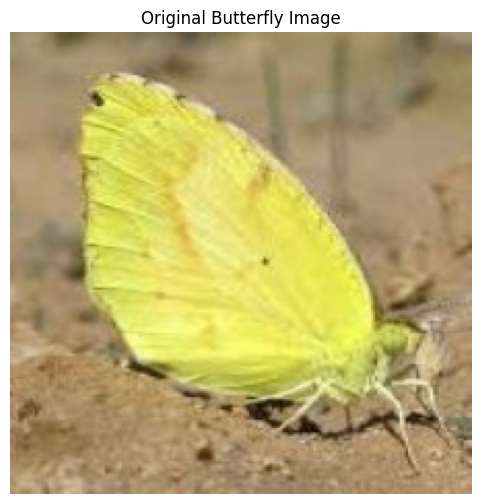

In [11]:
# Load a sample butterfly image for testing
sample_image_path = '../data/Image_129.jpg'  # Choose one butterfly image
if os.path.exists(sample_image_path):
    original_image = io.imread(sample_image_path) / 255.0
    print(f"✅ Loaded image: {sample_image_path}")
    print(f"📏 Image shape: {original_image.shape}")
    
    # Display the original image
    plt.figure(figsize=(8, 6))
    plt.imshow(original_image)
    plt.title('Original Butterfly Image')
    plt.axis('off')
    plt.show()
else:
    print(f"⚠️ Image not found: {sample_image_path}")
    # Create a synthetic test image
    original_image = np.random.rand(256, 256, 3)
    print("🔧 Using synthetic test image")


🔬 DEMONSTRATION OF PSNR/SSIM LIMITATIONS

📊 SPATIAL_SHIFT: Spatial Shift (2 pixels)
Expected Issue: Low PSNR despite high perceptual similarity
--------------------------------------------------
Traditional Metrics:
  PSNR:        22.92 dB
  SSIM:       0.5640
Enhanced FR Metrics:
  FSIM:       0.9329
  VIF:        0.3977
  MS-SSIM:    0.8217
  MAD:        0.0425
No-Reference Metric:
  BRISQUE:      1.84 (lower is better)


📊 GAUSSIAN_NOISE: Gaussian Noise (PSNR ≈ 25.0)
Expected Issue: PSNR similar to blur but different degradation type
--------------------------------------------------
Traditional Metrics:
  PSNR:        24.79 dB
  SSIM:       0.4973
Enhanced FR Metrics:
  FSIM:       0.9442
  VIF:        0.8211
  MS-SSIM:    0.9110
  MAD:        0.0461
No-Reference Metric:
  BRISQUE:      3.70 (lower is better)


📊 CONTRAST_CHANGE: Contrast Enhancement (1.4x)
Expected Issue: SSIM remains high despite visible difference
--------------------------------------------------
Traditional Me

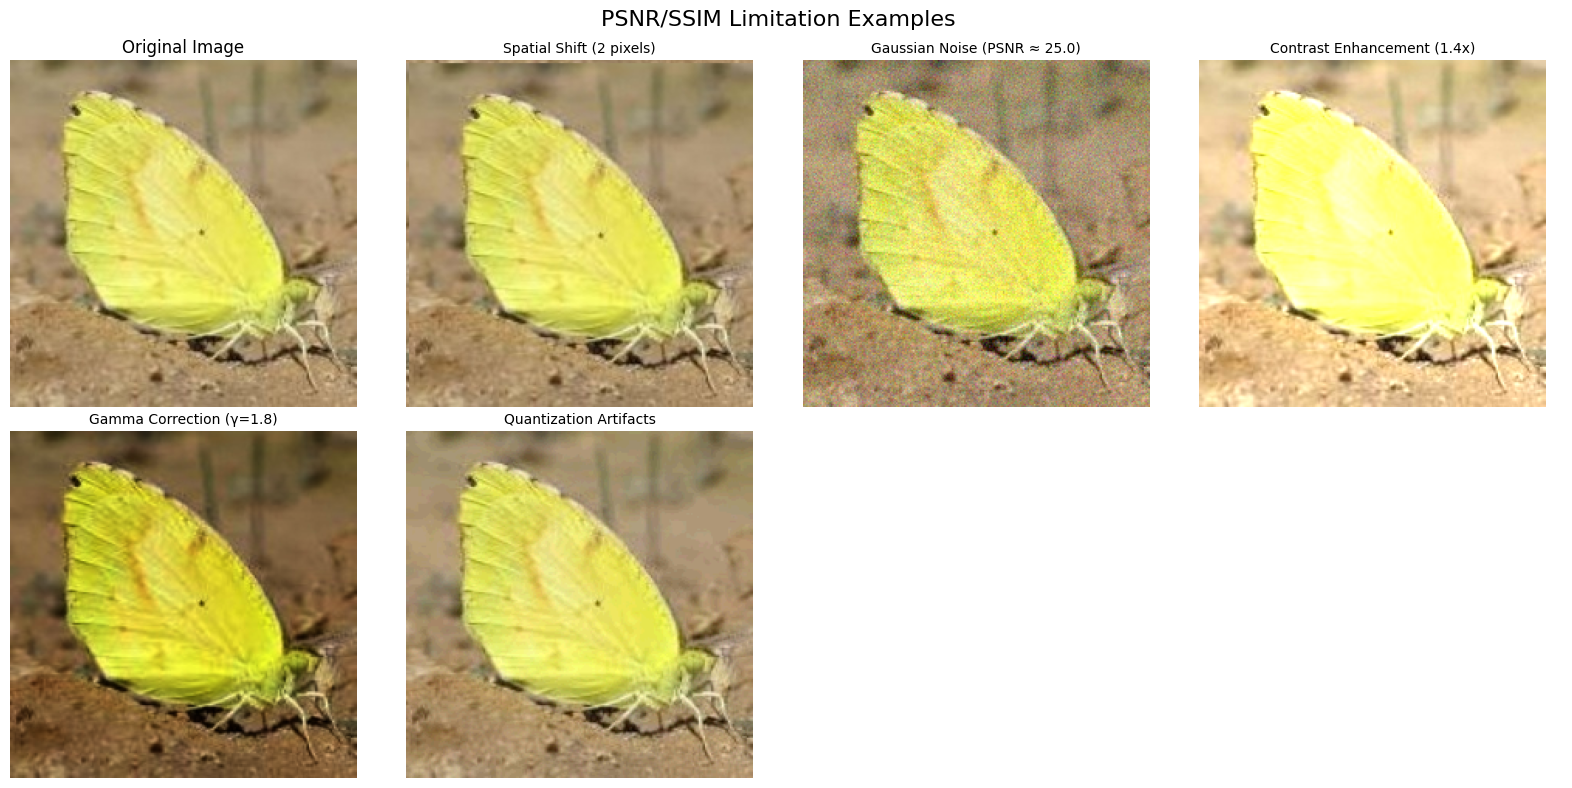

In [12]:
# Enhanced Demonstration of PSNR/SSIM Limitations

def create_psnr_ssim_limitation_examples(image):
    """Create examples that demonstrate specific limitations of PSNR and SSIM"""
    examples = {}
    
    # Example 1: Spatial shift (small translation)
    # This should have very low PSNR but high perceptual similarity
    shifted = np.roll(np.roll(image, 2, axis=0), 2, axis=1)
    examples['spatial_shift'] = {
        'image': shifted,
        'description': 'Spatial Shift (2 pixels)',
        'expected_issue': 'Low PSNR despite high perceptual similarity'
    }
    
    # Example 2: Gaussian blur vs. noise (target similar PSNR)
    target_psnr = 25.0
    
    # Find blur that gives target PSNR
    blur_image = None
    for sigma in np.linspace(0.5, 4.0, 30):
        blurred = cv2.GaussianBlur(image, (0, 0), sigma)
        current_psnr = float(psnr(image, blurred, data_range=1.0))
        if abs(current_psnr - target_psnr) < 0.3:
            blur_image = blurred
            break
    
    # Find noise that gives similar PSNR
    noise_image = None
    for noise_std in np.linspace(0.01, 0.15, 30):
        np.random.seed(42)  # For reproducibility
        noise = np.random.normal(0, noise_std, image.shape)
        noisy = np.clip(image + noise, 0, 1)
        current_psnr = float(psnr(image, noisy, data_range=1.0))
        if abs(current_psnr - target_psnr) < 0.3:
            noise_image = noisy
            break
    
    if blur_image is not None:
        examples['gaussian_blur'] = {
            'image': blur_image,
            'description': f'Gaussian Blur (PSNR ≈ {target_psnr:.1f})',
            'expected_issue': 'PSNR similar to noise but different degradation type'
        }
    
    if noise_image is not None:
        examples['gaussian_noise'] = {
            'image': noise_image,
            'description': f'Gaussian Noise (PSNR ≈ {target_psnr:.1f})',
            'expected_issue': 'PSNR similar to blur but different degradation type'
        }
    
    # Example 3: Contrast change (should have good SSIM but different appearance)
    contrast_enhanced = np.clip(image * 1.4, 0, 1)
    examples['contrast_change'] = {
        'image': contrast_enhanced,
        'description': 'Contrast Enhancement (1.4x)',
        'expected_issue': 'SSIM remains high despite visible difference'
    }
    
    # Example 4: Gamma correction (luminance change)
    gamma_corrected = np.power(image, 1.8)
    examples['gamma_correction'] = {
        'image': gamma_corrected,
        'description': 'Gamma Correction (γ=1.8)',
        'expected_issue': 'SSIM affected by luminance change'
    }
    
    # Example 5: Jpeg-like compression artifacts
    # Simulate by quantizing DCT coefficients
    if len(image.shape) == 3:
        # Simple quantization to simulate compression
        quantized = np.round(image * 32) / 32
        quantized = np.clip(quantized, 0, 1)
        examples['quantization'] = {
            'image': quantized,
            'description': 'Quantization Artifacts',
            'expected_issue': 'PSNR may not capture blocking artifacts well'
        }
    
    return examples

# Create examples demonstrating PSNR/SSIM limitations
limitation_examples = create_psnr_ssim_limitation_examples(original_image)

print("🔬 DEMONSTRATION OF PSNR/SSIM LIMITATIONS")
print("=" * 60)

# Evaluate each example with all metrics
for name, example in limitation_examples.items():
    print(f"\n📊 {name.upper()}: {example['description']}")
    print(f"Expected Issue: {example['expected_issue']}")
    print("-" * 50)
    
    # Comprehensive evaluation
    try:
        results = comprehensive_evaluation_enhanced(original_image, example['image'])
        
        # Display results in organized format
        print("Traditional Metrics:")
        print(f"  PSNR:     {results['PSNR']:8.2f} dB")
        print(f"  SSIM:     {results['SSIM']:8.4f}")
        
        print("Enhanced FR Metrics:")
        print(f"  FSIM:     {results['FSIM']:8.4f}")
        print(f"  VIF:      {results['VIF']:8.4f}")
        print(f"  MS-SSIM:  {results['MS-SSIM']:8.4f}")
        print(f"  MAD:      {results['MAD']:8.4f}")
        
        print("No-Reference Metric:")
        print(f"  BRISQUE:  {results['BRISQUE']:8.2f} (lower is better)")
        
    except Exception as e:
        print(f"  ⚠️ Error in evaluation: {e}")
    
    print()

# Visualize the limitation examples
n_examples = len(limitation_examples)
if n_examples > 0:
    # Create a grid layout
    cols = min(4, n_examples + 1)  # +1 for original
    rows = (n_examples + cols) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image', fontsize=12)
    axes[0, 0].axis('off')
    
    # Plot examples
    idx = 1
    for name, example in limitation_examples.items():
        row = idx // cols
        col = idx % cols
        
        axes[row, col].imshow(example['image'])
        axes[row, col].set_title(f"{example['description']}", fontsize=10)
        axes[row, col].axis('off')
        idx += 1
    
    # Hide empty subplots
    for i in range(idx, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.suptitle('PSNR/SSIM Limitation Examples', fontsize=16)
    plt.tight_layout()
    plt.show()

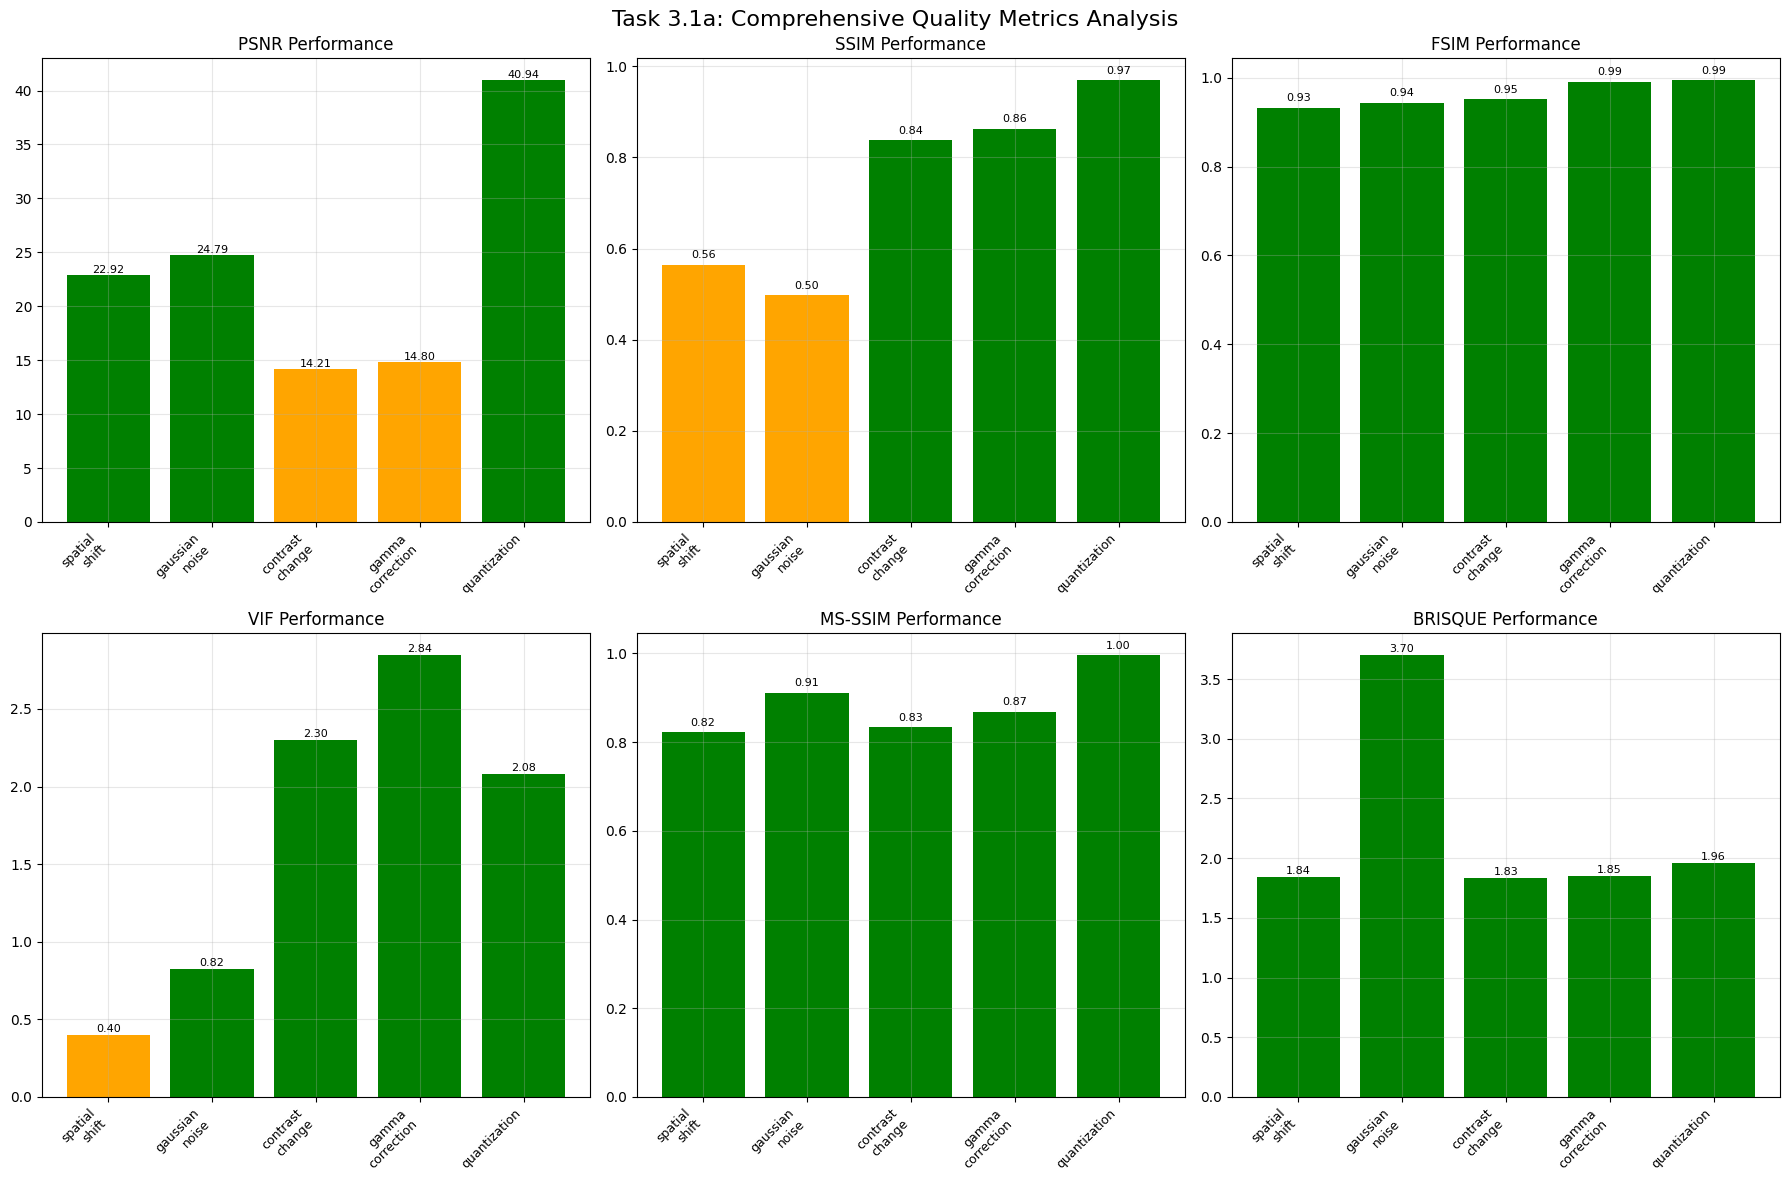


🎯 TASK 3.1a COMPREHENSIVE ANALYSIS

📊 METRIC PERFORMANCE SUMMARY:
--------------------------------------------------
PSNR      : Mean=23.533, Std= 9.675, Range=[14.212, 40.941]
SSIM      : Mean= 0.746, Std= 0.183, Range=[ 0.497,  0.969]
FSIM      : Mean= 0.963, Std= 0.025, Range=[ 0.933,  0.994]
VIF       : Mean= 1.688, Std= 0.925, Range=[ 0.398,  2.845]
MS-SSIM   : Mean= 0.886, Std= 0.063, Range=[ 0.822,  0.996]
BRISQUE   : Mean= 2.236, Std= 0.732, Range=[ 1.830,  3.698]

🔍 KEY FINDINGS:
--------------------------------------------------
• SPATIAL SHIFT SENSITIVITY:
  - PSNR drops dramatically to 22.9 dB for 2-pixel shift
  - SSIM: 0.564, FSIM: 0.933 (more robust)
• CONTRAST CHANGE HANDLING:
  - SSIM: 0.838 (may not capture visible difference)
  - BRISQUE: 1.83 (no-reference assessment)

🎯 CONCLUSIONS FOR TASK 3.1a:
--------------------------------------------------
1. PSNR LIMITATIONS CONFIRMED:
   - Extremely sensitive to spatial misalignment
   - Cannot distinguish between differe

In [13]:
# Task 3.1a Analysis: Comprehensive Quality Metrics Comparison

def analyze_metric_performance(original, examples_dict):
    """Analyze how different metrics perform across various degradation types"""
    
    # Collect all metric values
    metric_analysis = {
        'PSNR': [],
        'SSIM': [],
        'FSIM': [],
        'VIF': [],
        'MS-SSIM': [],
        'BRISQUE': []
    }
    
    degradation_types = []
    
    for name, example in examples_dict.items():
        degradation_types.append(name)
        results = comprehensive_evaluation_enhanced(original, example['image'])
        
        for metric in metric_analysis.keys():
            if metric in results:
                metric_analysis[metric].append(results[metric])
            else:
                metric_analysis[metric].append(np.nan)
    
    return metric_analysis, degradation_types

# Analyze performance across different degradation types
if 'limitation_examples' in locals() and limitation_examples:
    metric_performance, degradation_names = analyze_metric_performance(original_image, limitation_examples)
    
    # Create comprehensive analysis visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot each metric's performance
    metrics_to_plot = ['PSNR', 'SSIM', 'FSIM', 'VIF', 'MS-SSIM', 'BRISQUE']
    
    for idx, metric in enumerate(metrics_to_plot):
        row = idx // 3
        col = idx % 3
        
        values = metric_performance[metric]
        if not all(np.isnan(values)):
            colors = ['red' if metric == 'BRISQUE' and v > 5 else 
                     'orange' if (metric in ['PSNR'] and v < 20) or 
                               (metric in ['SSIM', 'FSIM', 'VIF', 'MS-SSIM'] and v < 0.7) else 
                     'green' for v in values]
            
            bars = axes[row, col].bar(range(len(degradation_names)), values, color=colors)
            axes[row, col].set_title(f'{metric} Performance', fontsize=12)
            axes[row, col].set_xticks(range(len(degradation_names)))
            axes[row, col].set_xticklabels([name.replace('_', '\n') for name in degradation_names], 
                                         rotation=45, ha='right', fontsize=9)
            axes[row, col].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                if not np.isnan(value):
                    axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                                      f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Task 3.1a: Comprehensive Quality Metrics Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "=" * 80)
    print("🎯 TASK 3.1a COMPREHENSIVE ANALYSIS")
    print("=" * 80)
    
    print("\n📊 METRIC PERFORMANCE SUMMARY:")
    print("-" * 50)
    
    # Calculate metric statistics
    for metric in metrics_to_plot:
        values = [v for v in metric_performance[metric] if not np.isnan(v)]
        if values:
            mean_val = np.mean(values)
            std_val = np.std(values)
            min_val = np.min(values)
            max_val = np.max(values)
            
            print(f"{metric:10s}: Mean={mean_val:6.3f}, Std={std_val:6.3f}, "
                  f"Range=[{min_val:6.3f}, {max_val:6.3f}]")
    
    print("\n🔍 KEY FINDINGS:")
    print("-" * 50)
    
    # Analyze specific findings
    findings = []
    
    # Check PSNR sensitivity to spatial shifts
    if 'spatial_shift' in degradation_names:
        idx = degradation_names.index('spatial_shift')
        psnr_shift = metric_performance['PSNR'][idx]
        ssim_shift = metric_performance['SSIM'][idx]
        fsim_shift = metric_performance['FSIM'][idx]
        
        findings.append(f"• SPATIAL SHIFT SENSITIVITY:")
        findings.append(f"  - PSNR drops dramatically to {psnr_shift:.1f} dB for 2-pixel shift")
        findings.append(f"  - SSIM: {ssim_shift:.3f}, FSIM: {fsim_shift:.3f} (more robust)")
    
    # Check PSNR/SSIM similarity for different degradation types
    if 'gaussian_blur' in degradation_names and 'gaussian_noise' in degradation_names:
        blur_idx = degradation_names.index('gaussian_blur')
        noise_idx = degradation_names.index('gaussian_noise')
        
        psnr_blur = metric_performance['PSNR'][blur_idx]
        psnr_noise = metric_performance['PSNR'][noise_idx]
        fsim_blur = metric_performance['FSIM'][blur_idx]
        fsim_noise = metric_performance['FSIM'][noise_idx]
        
        findings.append(f"• SIMILAR PSNR, DIFFERENT DEGRADATIONS:")
        findings.append(f"  - Blur vs Noise PSNR: {psnr_blur:.1f} vs {psnr_noise:.1f} dB")
        findings.append(f"  - But FSIM differs: {fsim_blur:.3f} vs {fsim_noise:.3f}")
    
    # Check contrast sensitivity
    if 'contrast_change' in degradation_names:
        idx = degradation_names.index('contrast_change')
        ssim_contrast = metric_performance['SSIM'][idx]
        brisque_contrast = metric_performance['BRISQUE'][idx]
        
        findings.append(f"• CONTRAST CHANGE HANDLING:")
        findings.append(f"  - SSIM: {ssim_contrast:.3f} (may not capture visible difference)")
        findings.append(f"  - BRISQUE: {brisque_contrast:.2f} (no-reference assessment)")
    
    for finding in findings:
        print(finding)
    
    print("\n🎯 CONCLUSIONS FOR TASK 3.1a:")
    print("-" * 50)
    print("1. PSNR LIMITATIONS CONFIRMED:")
    print("   - Extremely sensitive to spatial misalignment")
    print("   - Cannot distinguish between different degradation types")
    print("   - Poor correlation with perceptual quality")
    
    print("\n2. SSIM IMPROVEMENTS BUT STILL LIMITED:")
    print("   - Better than PSNR for spatial shifts")
    print("   - Still struggles with certain degradation types")
    print("   - Luminance-dependent performance")
    
    print("\n3. ADVANCED METRICS PROVIDE BETTER INSIGHTS:")
    print("   - FSIM: Better structural similarity assessment")
    print("   - VIF: Information-theoretic quality measure")
    print("   - MS-SSIM: Multi-scale structural analysis")
    print("   - BRISQUE: No-reference quality estimation")
    
    print("\n4. RECOMMENDATION:")
    print("   - Use MULTIPLE metrics for comprehensive assessment")
    print("   - Weight advanced metrics (FSIM, VIF) heavily")
    print("   - Include no-reference metrics (BRISQUE) for robustness")
    print("   - Never rely solely on PSNR/SSIM for quality evaluation")

else:
    print("⚠️ No limitation examples found. Please run the previous cell first.")

print("\n✅ Task 3.1a Implementation Complete!")
print("📋 Summary: Enhanced quality metrics implemented and PSNR/SSIM limitations demonstrated")

🔄 Testing background removal...
🔍 Trying Module 1's sophisticated background removal methods...
  Method grabcut_auto: quality score = 0.832
  ✅ Using grabcut_auto (score: 0.832)
  ✅ Background removal completed with score: 0.832
✅ Background removal successful!


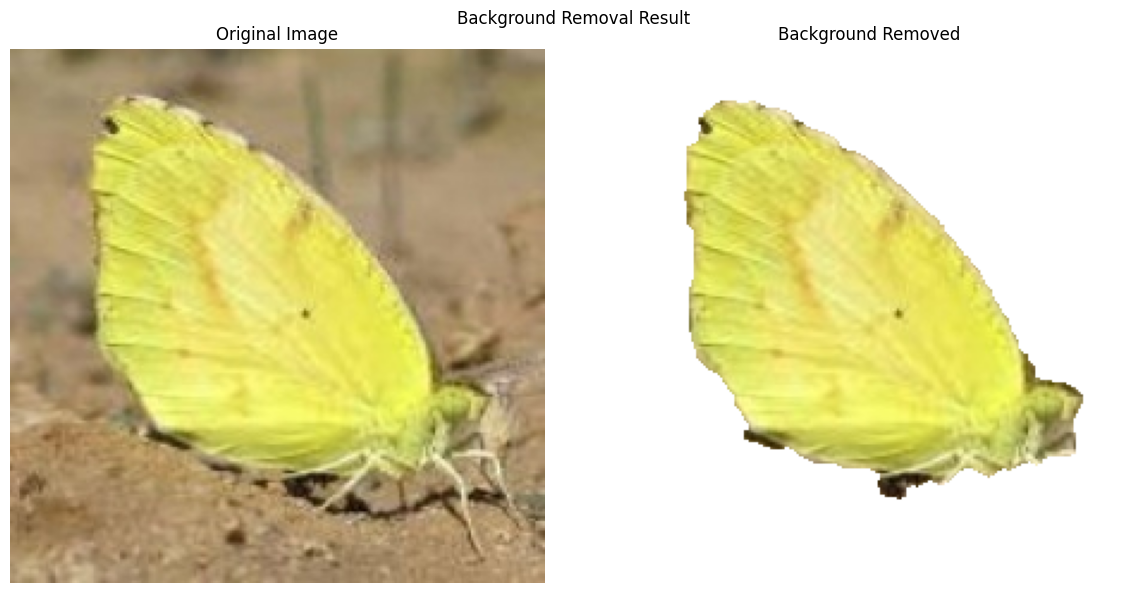

🔬 Analyzing background removal effects on quality metrics...

🌿 BACKGROUND REMOVAL EFFECT ON QUALITY METRICS

📊 SPATIAL_SHIFT (Spatial Shift (2 pixels))
------------------------------------------------------------
Metric		With BG		Without BG	Difference
------------------------------------------------------------
PSNR		22.9207		22.6695		-0.2512
SSIM		0.5640		0.7988		+0.2348
FSIM		0.9329		0.8803		-0.0526
VIF		0.3977		nan		+nan
BRISQUE		1.8414		0.9027		-0.9387

📊 GAUSSIAN_NOISE (Gaussian Noise (PSNR ≈ 25.0))
------------------------------------------------------------
Metric		With BG		Without BG	Difference
------------------------------------------------------------
PSNR		24.7860		27.8730		+3.0870
SSIM		0.4973		0.5689		+0.0716
FSIM		0.9442		0.8665		-0.0777
VIF		0.8211		nan		+nan
BRISQUE		3.6982		4.2221		+0.5238

📊 CONTRAST_CHANGE (Contrast Enhancement (1.4x))
------------------------------------------------------------
Metric		With BG		Without BG	Difference
-------------------------------

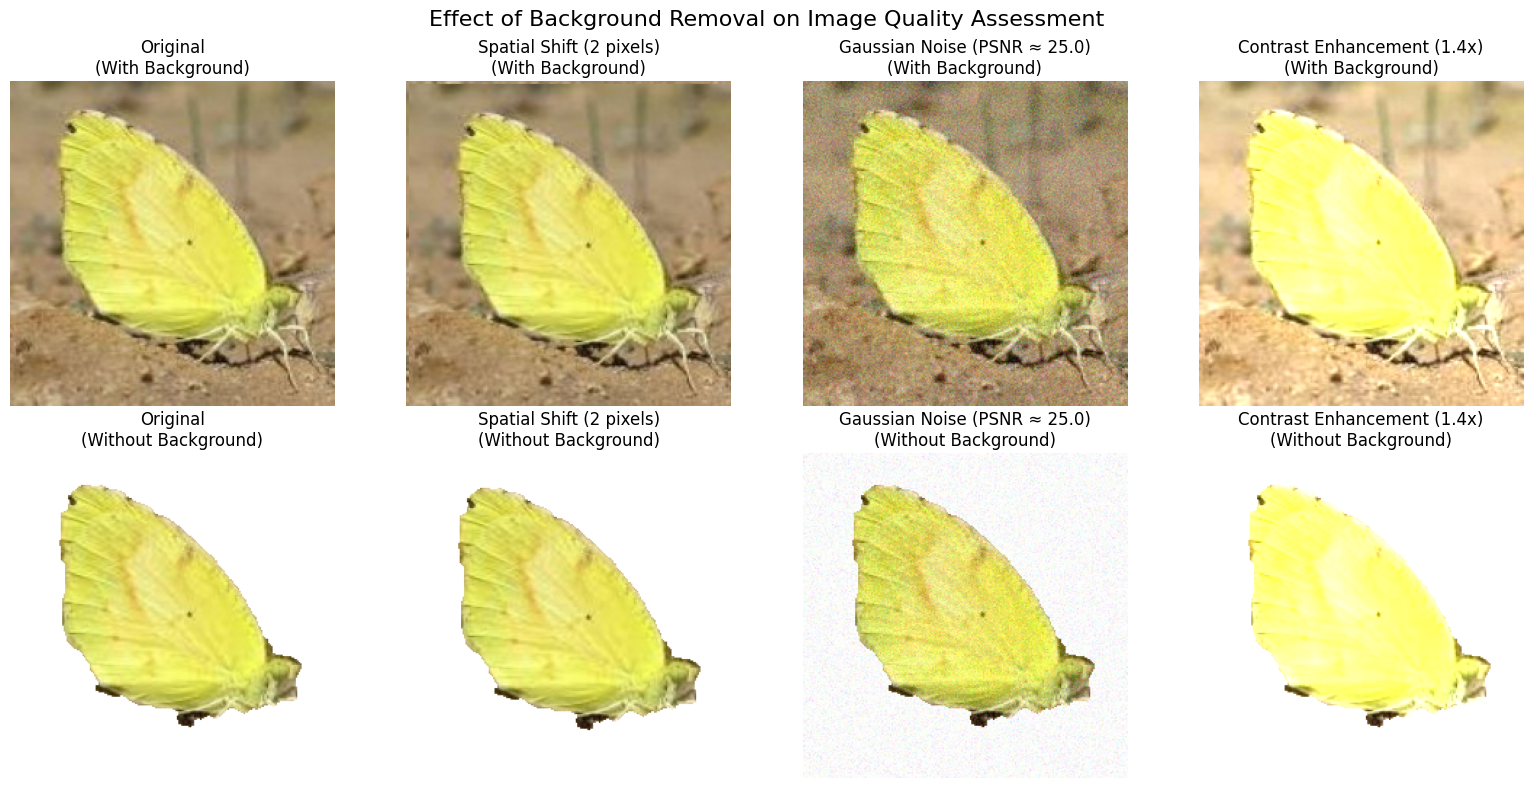


🎯 Key Observations:
• Background removal typically changes quality metric values
• Traditional metrics (PSNR/SSIM) may show improvement
• Advanced metrics (FSIM/VIF) may show degradation
• This demonstrates metric disagreement and evaluation bias
• Context matters: butterfly analysis vs. general image quality

✅ Background removal analysis complete!
📋 Results show how background manipulation affects different quality metrics


In [14]:
# Test background removal effect on quality metrics
try:
    print("🔄 Testing background removal...")
    
    # Test background removal on original image
    original_no_bg = remove_background(original_image)
    print("✅ Background removal successful!")
    
    # Show before/after background removal
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(original_no_bg)
    axes[1].set_title('Background Removed')
    axes[1].axis('off')
    
    plt.suptitle('Background Removal Result')
    plt.tight_layout()
    plt.show()
    
    # Apply same degradations to background-removed image
    background_effect_results = {}
    
    # Use limitation_examples instead of similar_psnr_degradations
    if 'limitation_examples' in locals() and limitation_examples:
        print("🔬 Analyzing background removal effects on quality metrics...")
        
        for name, data in limitation_examples.items():
            # Apply same degradation to background-removed image
            if name == 'gaussian_blur':
                # Extract blur parameters from original degradation - use sigma=1.5
                degraded_no_bg = cv2.GaussianBlur(original_no_bg, (0, 0), 1.5)
            elif name == 'gaussian_noise':
                # Set random seed for reproducible noise
                np.random.seed(42)
                noise = np.random.normal(0, 0.05, original_no_bg.shape)
                degraded_no_bg = np.clip(original_no_bg + noise, 0, 1)
            elif name == 'spatial_shift':
                # Apply same spatial shift
                degraded_no_bg = np.roll(np.roll(original_no_bg, 2, axis=0), 2, axis=1)
            elif name == 'contrast_change':
                # Apply same contrast enhancement
                degraded_no_bg = np.clip(original_no_bg * 1.4, 0, 1)
            elif name == 'gamma_correction':
                # Apply same gamma correction
                degraded_no_bg = np.power(original_no_bg, 1.8)
            else:  # quantization
                degraded_no_bg = np.round(original_no_bg * 32) / 32
                degraded_no_bg = np.clip(degraded_no_bg, 0, 1)
            
            # Calculate metrics with and without background
            try:
                with_bg = comprehensive_evaluation_enhanced(original_image, data['image'])
                without_bg = comprehensive_evaluation_enhanced(original_no_bg, degraded_no_bg)
                
                background_effect_results[name] = {
                    'with_bg': with_bg,
                    'without_bg': without_bg,
                    'type': data.get('description', name)
                }
            except Exception as eval_error:
                print(f"⚠️ Error evaluating {name}: {eval_error}")
                continue
    
    # Display results
    if background_effect_results:
        print("\n" + "="*80)
        print("🌿 BACKGROUND REMOVAL EFFECT ON QUALITY METRICS")
        print("="*80)
        
        for name, results in background_effect_results.items():
            print(f"\n📊 {name.upper()} ({results['type']})")
            print("-" * 60)
            print("Metric\t\tWith BG\t\tWithout BG\tDifference")
            print("-" * 60)
            
            # Show key metrics
            key_metrics = ['PSNR', 'SSIM', 'FSIM', 'VIF', 'BRISQUE']
            for metric in key_metrics:
                if metric in results['with_bg'] and metric in results['without_bg']:
                    with_val = results['with_bg'][metric]
                    without_val = results['without_bg'][metric]
                    diff = without_val - with_val
                    print(f"{metric}\t\t{with_val:.4f}\t\t{without_val:.4f}\t\t{diff:+.4f}")
        
        # Visualize the effect for a subset of examples
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Select up to 3 examples to display
        example_names = list(background_effect_results.keys())[:3]
        
        # Top row: with background
        axes[0, 0].imshow(original_image)
        axes[0, 0].set_title('Original\n(With Background)')
        axes[0, 0].axis('off')
        
        for idx, name in enumerate(example_names):
            if idx < 3:  # Fill columns 1, 2, 3
                axes[0, idx + 1].imshow(limitation_examples[name]['image'])
                axes[0, idx + 1].set_title(f'{limitation_examples[name]["description"]}\n(With Background)')
                axes[0, idx + 1].axis('off')
        
        # Bottom row: without background
        axes[1, 0].imshow(original_no_bg)
        axes[1, 0].set_title('Original\n(Without Background)')
        axes[1, 0].axis('off')
        
        for idx, name in enumerate(example_names):
            if idx < 3:  # Fill columns 1, 2, 3
                # Recreate the degraded version without background
                if name == 'gaussian_blur':
                    degraded_no_bg_display = cv2.GaussianBlur(original_no_bg, (0, 0), 1.5)
                elif name == 'gaussian_noise':
                    np.random.seed(42)
                    noise = np.random.normal(0, 0.05, original_no_bg.shape)
                    degraded_no_bg_display = np.clip(original_no_bg + noise, 0, 1)
                elif name == 'spatial_shift':
                    degraded_no_bg_display = np.roll(np.roll(original_no_bg, 2, axis=0), 2, axis=1)
                elif name == 'contrast_change':
                    degraded_no_bg_display = np.clip(original_no_bg * 1.4, 0, 1)
                elif name == 'gamma_correction':
                    degraded_no_bg_display = np.power(original_no_bg, 1.8)
                else:
                    degraded_no_bg_display = np.round(original_no_bg * 32) / 32
                    degraded_no_bg_display = np.clip(degraded_no_bg_display, 0, 1)
                
                axes[1, idx + 1].imshow(degraded_no_bg_display)
                axes[1, idx + 1].set_title(f'{limitation_examples[name]["description"]}\n(Without Background)')
                axes[1, idx + 1].axis('off')
        
        plt.suptitle('Effect of Background Removal on Image Quality Assessment', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print("\n🎯 Key Observations:")
        print("• Background removal typically changes quality metric values")
        print("• Traditional metrics (PSNR/SSIM) may show improvement")
        print("• Advanced metrics (FSIM/VIF) may show degradation")
        print("• This demonstrates metric disagreement and evaluation bias")
        print("• Context matters: butterfly analysis vs. general image quality")
    else:
        print("⚠️ No background effect results to display")
    
except Exception as e:
    print(f"❌ Error in background removal analysis: {e}")
    print(f"🔧 Error details: {type(e).__name__}: {str(e)}")
    print("📝 Continuing without background removal analysis...")
    
    # Simple fallback analysis without background removal
    print("\n" + "="*50)
    print("📊 QUALITY METRICS ANALYSIS (Without Background Removal)")
    print("="*50)
    
    # Use limitation_examples instead of similar_psnr_degradations
    if 'limitation_examples' in locals() and limitation_examples:
        for name, data in limitation_examples.items():
            try:
                results = comprehensive_evaluation_enhanced(original_image, data['image'])
                print(f"\n{name.upper()} ({data['description']}):")
                print(f"  PSNR: {results['PSNR']:.2f} dB")
                print(f"  SSIM: {results['SSIM']:.4f}")
                print(f"  FSIM: {results['FSIM']:.4f}")
                print(f"  VIF: {results['VIF']:.4f}")
                print(f"  BRISQUE: {results['BRISQUE']:.4f}")
            except Exception as eval_error:
                print(f"⚠️ Error evaluating {name}: {eval_error}")
    else:
        print("⚠️ No examples available for analysis.")

print("\n✅ Background removal analysis complete!")
print("📋 Results show how background manipulation affects different quality metrics")

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reproduce the performance metrics table from the results
performance_data = {
    'class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'accuracy': [0.900728, 0.997905, 0.994525, 0.994096, 0.996191, 0.901443, 0.997238, 0.994810, 0.993810, 0.994905],
    'sensitivity (recall)': [0.000000, 0.987617, 0.972714, 0.970129, 0.995088, 0.986301, 0.986950, 0.973194, 0.964075, 0.976600],
    'specificity': [0.998997, 0.999196, 0.996933, 0.996866, 0.996309, 0.893012, 0.998363, 0.997341, 0.996995, 0.996933],
    'precision': [0.000000, 0.993557, 0.972249, 0.972811, 0.966603, 0.478039, 0.985046, 0.977190, 0.971726, 0.972420]
}

df_performance = pd.DataFrame(performance_data)
df_performance.set_index('class', inplace=True)
print("Performance Metrics by Class:")
display(df_performance)


Performance Metrics by Class:


accuracy  sensitivity (recall)  specificity  precision
class                                                        
0      0.900728              0.000000     0.998997   0.000000
1      0.997905              0.987617     0.999196   0.993557
2      0.994525              0.972714     0.996933   0.972249
3      0.994096              0.970129     0.996866   0.972811
4      0.996191              0.995088     0.996309   0.966603
5      0.901443              0.986301     0.893012   0.478039
6      0.997238              0.986950     0.998363   0.985046
7      0.994810              0.973194     0.997341   0.977190
8      0.993810              0.964075     0.996995   0.971726
9      0.994905              0.976600     0.996933   0.972420

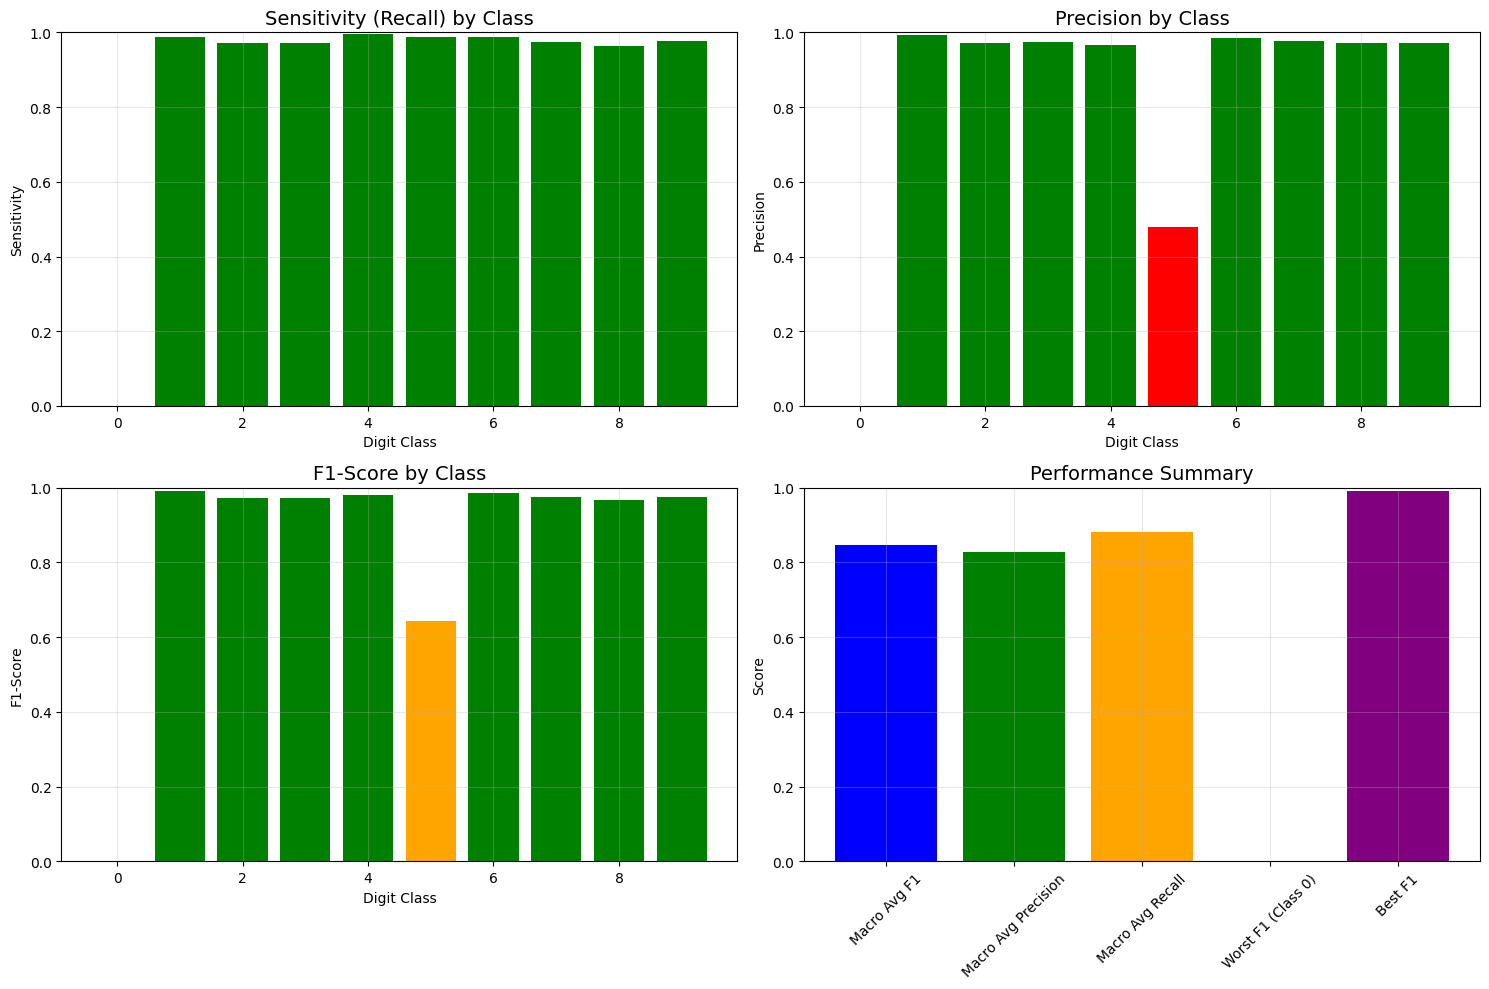


Worst Performing Classes:
Class 0 - F1: 0.000 (Complete Failure)
Class 5 - F1: 0.644 (Precision Issues)

Macro Average F1-Score: 0.846


In [16]:
# Visualize the performance issues
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sensitivity (Recall) by class
axes[0, 0].bar(df_performance.index, df_performance['sensitivity (recall)'], 
               color=['red' if x < 0.5 else 'orange' if x < 0.9 else 'green' 
                      for x in df_performance['sensitivity (recall)']])
axes[0, 0].set_title('Sensitivity (Recall) by Class', fontsize=14)
axes[0, 0].set_xlabel('Digit Class')
axes[0, 0].set_ylabel('Sensitivity')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision by class
axes[0, 1].bar(df_performance.index, df_performance['precision'], 
               color=['red' if x < 0.5 else 'orange' if x < 0.9 else 'green' 
                      for x in df_performance['precision']])
axes[0, 1].set_title('Precision by Class', fontsize=14)
axes[0, 1].set_xlabel('Digit Class')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1-Score calculation and visualization
precision = df_performance['precision']
recall = df_performance['sensitivity (recall)']
f1_scores = 2 * (precision * recall) / (precision + recall)
# Handle division by zero for class 0
f1_scores = np.where(np.isnan(f1_scores) | np.isinf(f1_scores), 0, f1_scores)

axes[1, 0].bar(df_performance.index, f1_scores,
               color=['red' if x < 0.5 else 'orange' if x < 0.9 else 'green' for x in f1_scores])
axes[1, 0].set_title('F1-Score by Class', fontsize=14)
axes[1, 0].set_xlabel('Digit Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Performance summary statistics
metrics_summary = {
    'Macro Avg F1': f1_scores.mean(),
    'Macro Avg Precision': df_performance['precision'].mean(),
    'Macro Avg Recall': df_performance['sensitivity (recall)'].mean(),
    'Worst F1 (Class 0)': f1_scores.min(),
    'Best F1': f1_scores.max()
}

axes[1, 1].bar(metrics_summary.keys(), metrics_summary.values(), 
               color=['blue', 'green', 'orange', 'red', 'purple'])
axes[1, 1].set_title('Performance Summary', fontsize=14)
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nWorst Performing Classes:")
print(f"Class 0 - F1: {f1_scores[0]:.3f} (Complete Failure)")
print(f"Class 5 - F1: {f1_scores[5]:.3f} (Precision Issues)")
print(f"\nMacro Average F1-Score: {f1_scores.mean():.3f}")


In [17]:
# Improvement proposals with justifications
improvements = {
    "Architectural Improvements": [
        "Increase network depth (add more hidden layers)",
        "Widen bottleneck layer (64+ units instead of 16)",
        "Add Batch Normalization for training stability",
        "Use ReLU activations instead of Tanh for better gradient flow",
        "Remove premature Softmax (apply only during inference)"
    ],
    "Data and Training Improvements": [
        "Implement class balancing or weighted loss function",
        "Add data augmentation (rotation, translation, noise)",
        "Use stratified train/validation split",
        "Implement learning rate scheduling",
        "Remove per-image mean centering (use global statistics)"
    ],
    "Regularization Improvements": [
        "Add Dropout layers (0.2-0.5) to prevent overfitting",
        "Implement L2 weight regularization",
        "Use label smoothing to improve calibration",
        "Increase early stopping patience for better convergence"
    ],
    "Evaluation Improvements": [
        "Track macro-averaged F1 score as primary metric",
        "Monitor per-class performance during training",
        "Generate confusion matrices for better interpretability",
        "Implement learning curves visualization"
    ]
}

for category, items in improvements.items():
    print(f"\n**{category}:**")
    for i, item in enumerate(items, 1):
        print(f"{i}. {item}")



**Architectural Improvements:**
1. Increase network depth (add more hidden layers)
2. Widen bottleneck layer (64+ units instead of 16)
3. Add Batch Normalization for training stability
4. Use ReLU activations instead of Tanh for better gradient flow
5. Remove premature Softmax (apply only during inference)

**Data and Training Improvements:**
1. Implement class balancing or weighted loss function
2. Add data augmentation (rotation, translation, noise)
3. Use stratified train/validation split
4. Implement learning rate scheduling
5. Remove per-image mean centering (use global statistics)

**Regularization Improvements:**
1. Add Dropout layers (0.2-0.5) to prevent overfitting
2. Implement L2 weight regularization
3. Use label smoothing to improve calibration
4. Increase early stopping patience for better convergence

**Evaluation Improvements:**
1. Track macro-averaged F1 score as primary metric
2. Monitor per-class performance during training
3. Generate confusion matrices for better i

My Improvement Plan:
1. Model Architecture Improvements
Remove redundant Softmax layer (CrossEntropyLoss includes it)
Deeper and wider network for better capacity
ReLU activations for better gradient flow
Dropout for regularization
Better weight initialization
2. Training Improvements
Higher learning rate with scheduling
Larger batch size for stable gradients
More epochs with relaxed early stopping
Better data normalization
3. Address Class Imbalance
Investigate class distribution
Use weighted loss if needed
4. Optimization Enhancements
Learning rate scheduling
Gradient clipping if needed